In [1]:
from scipy.misc import imsave, imresize, imread
import time

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# tool box
from keras.applications.vgg16 import VGG16
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
from style_transfer_utils import resize_image, preprocess_image, deprocess_image
print(resize_image.__doc__)
print(preprocess_image.__doc__)
print(deprocess_image.__doc__)

None
None
None


In [4]:
# some style images
starry_night_path = '../images/starry_night.jpg'
udnie_path = '../images/udnie.jpg'


# some content images
vexin_path = '../images/vexin.jpg'
dog_path = '../images/dog.jpg'
golden_path = '../images/golden_retriever.jpg'
laska_path = '../images/laska.png'
train_path = '../images/hongkong.jpg'

## Open and resize content + style images

content_img_raw : (1070, 1600, 3)
style_img_raw : (599, 757, 3)


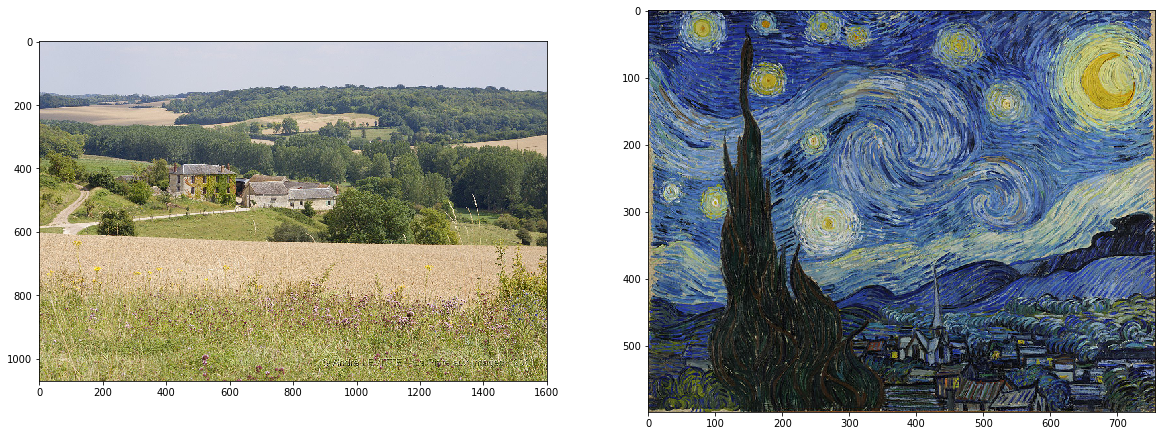

In [5]:
content_img_raw = imread(vexin_path)
style_img_raw = imread(starry_night_path)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(content_img_raw)
plt.subplot(122)
plt.imshow(style_img_raw)
print("content_img_raw : {}".format(content_img_raw.shape))
print("style_img_raw : {}".format(style_img_raw.shape))

- content image and generated image must have the same shape (to have the same feature maps)
- normally content and generated images can have a different shape than the style image (shapes of Gram matrices are invariant w.r.t. input shape)
- but, here, for simplicity, both images will have the same shape !

content_img_raw : (512, 512, 3)
style_img_raw : (512, 512, 3)


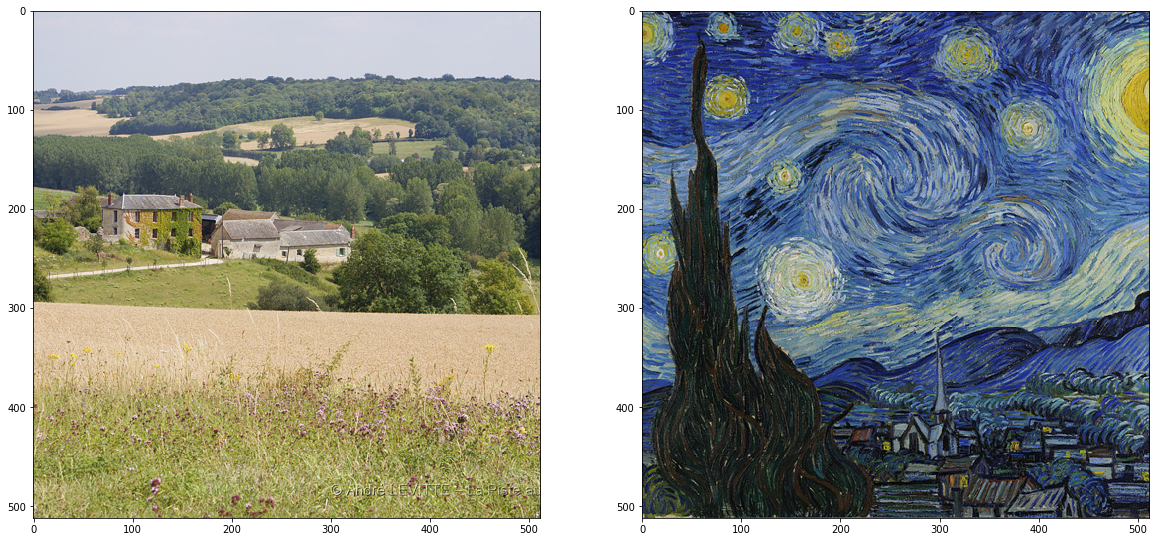

In [6]:
img_height, img_width = 512, 512

content_img_raw = resize_image(content_img_raw, target_size=(img_height,img_width))
style_img_raw = resize_image(style_img_raw, target_size=(img_width, img_width))

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(content_img_raw)
plt.subplot(122)
plt.imshow(style_img_raw)
print("content_img_raw : {}".format(content_img_raw.shape))
print("style_img_raw : {}".format(style_img_raw.shape))

## Visualize the Gram matrix

In [7]:
vgg16 = VGG16(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)

In [8]:
f_map = vgg16.get_layer('block2_conv2').output
print(f_map)
model = Model(inputs=vgg16.input, outputs=f_map)

Tensor("block2_conv2/Relu:0", shape=(?, 256, 256, 128), dtype=float32)


In [9]:
feature_maps = model.predict(preprocess_image(style_img_raw))[0]
print(feature_maps.shape)

(256, 256, 128)


In [10]:
# raw formula with 
gram_matrix = np.zeros((128, 128), dtype=np.float32)
for i in range(128):
    for j in range(128):
        gram_matrix[i,j] = np.mean(np.multiply(feature_maps[:,:,i], feature_maps[:,:,j]))

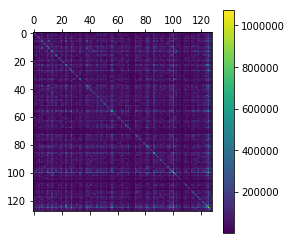

In [11]:
plt.matshow(gram_matrix)
plt.colorbar()

## Create the computational graph, using a pre-trained VGG16

- create constant tensors with content and style images (K.constant())
- create a variable (trainable) containning random values (K.variable())
- combine theses elements into one batch (batch_size = 3) (K.concatenate())

In [12]:
content_img_tensor = K.constant(preprocess_image(content_img_raw))
style_img_tensor = K.constant(preprocess_image(style_img_raw))

stylized_img_tensor = K.variable(np.random.normal(size=(1, img_height, img_width, 3), loc=0., scale=0.1))

print(stylized_img_tensor)

<tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32_ref>


In [13]:
input_tensor = K.concatenate([content_img_tensor, style_img_tensor, stylized_img_tensor], axis=0)
print(input_tensor)

Tensor("concat:0", shape=(3, 512, 512, 3), dtype=float32)


- give to a vgg model this tensor (use `input_tensor` parameter in VGG16)

In [14]:
vgg16 = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
[(layer.name, layer) for layer in vgg16.layers]

[('input_2', <keras.engine.topology.InputLayer at 0x7ffb79e934e0>),
 ('block1_conv1', <keras.layers.convolutional.Conv2D at 0x7ffb79e93438>),
 ('block1_conv2', <keras.layers.convolutional.Conv2D at 0x7ffb79e93c50>),
 ('block1_pool', <keras.layers.pooling.MaxPooling2D at 0x7ffb79e63710>),
 ('block2_conv1', <keras.layers.convolutional.Conv2D at 0x7ffb79e08cc0>),
 ('block2_conv2', <keras.layers.convolutional.Conv2D at 0x7ffb79e1ac50>),
 ('block2_pool', <keras.layers.pooling.MaxPooling2D at 0x7ffb79e2b0b8>),
 ('block3_conv1', <keras.layers.convolutional.Conv2D at 0x7ffb79dcd7f0>),
 ('block3_conv2', <keras.layers.convolutional.Conv2D at 0x7ffb79dded30>),
 ('block3_conv3', <keras.layers.convolutional.Conv2D at 0x7ffb79def898>),
 ('block3_pool', <keras.layers.pooling.MaxPooling2D at 0x7ffb79d906a0>),
 ('block4_conv1', <keras.layers.convolutional.Conv2D at 0x7ffb79db4a20>),
 ('block4_conv2', <keras.layers.convolutional.Conv2D at 0x7ffb79db4c50>),
 ('block4_conv3', <keras.layers.convolutional.C

## Compute the 'Content loss'
- with `block2_conv2` ? 
- can use K.sum() (or K.mean()) and K.square()

In [15]:
# here, we will use the feature maps from level `block2_conv2`
features_layer = vgg16.get_layer('block2_conv2').output
print(features_layer)

Tensor("block2_conv2_1/Relu:0", shape=(3, 256, 256, 128), dtype=float32)


In [16]:
# image 0 : content image
content_features = features_layer[0,:,:,:]
# image 2 : generated image
generated_features = features_layer[2,:,:,:]
    
# MSE on feature maps !
content_loss = K.sum(K.square(content_features-generated_features))
print(content_loss)

Tensor("Sum:0", shape=(), dtype=float32)


## Compute the 'Style loss' 
- at different layers, compute the gram matrices for style and generated images 
- then compute the MSE
- tool box : K.batch_flatten(), K.permute_dimensiones(), K.transpose(), K.dot()

In [17]:
def gram_matrix(x):
    """
    x : Tensor representing the features maps at a specific layer 
    Example : a tensor with this shape (256, 256, 128)
    """
    features = K.batch_flatten(K.permute_dimensions(x, (2,0,1)))
    gram_matrix = K.dot(features, K.transpose(features))
    return gram_matrix

In [18]:
style_layers = [('block1_conv2', 1.),
                ('block2_conv2', 1.),
                ('block3_conv3', 1.),
                ('block4_conv3', 1.)]

In [20]:
# create a scalar variable
style_loss = K.variable(0.)

for layer_name, weight in style_layers:
    # get the right output tensor 
    layer_features = vgg16.get_layer(layer_name).output
        
    # batch_size, + shape for the current feature map
    b, h, w, c = layer_features.shape.as_list()
    print("layer : {}  -> {}".format(layer_name, (b,h,w,c)))
        
    # image 1 : style image
    style_features = layer_features[1, :, :, :]
        
    # image 2 : generated image
    generated_features = layer_features[2, :, :, :]
        
    # compute the gram matrices   
    S = gram_matrix(style_features)
    G = gram_matrix(generated_features)
    
    # MSE on gram matrices (weighted sum)
    style_loss += weight * K.sum(K.square(S-G)) / (4. * ((c*h*w)**2))
    
    
print(style_loss)

layer : block1_conv2  -> (3, 512, 512, 64)
layer : block2_conv2  -> (3, 256, 256, 128)
layer : block3_conv3  -> (3, 128, 128, 256)
layer : block4_conv3  -> (3, 64, 64, 512)
Tensor("add_3:0", shape=(), dtype=float32)


## Add a Total Variation Loss (smooth images)
- only applied to 'stylized_img_tensor'

In [21]:
def total_variation_loss(img):
    a = K.square( img[:, :img_height - 1, :img_width - 1, :] - img[:, 1:, :img_width -1, :])
    b = K.square( img[:, :img_height - 1, :img_width - 1, :] - img[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a+b, 1.25))

In [22]:
tv_loss = total_variation_loss(stylized_img_tensor)
print(tv_loss)

Tensor("Sum_5:0", shape=(), dtype=float32)


## Combine the loss

In [23]:
alpha = 0.025 # content loss
beta = 500. # style loss
gamma = 1e-4 # total variation loss

loss = alpha*content_loss + beta*style_loss # + gamma*tv_loss

## Train `stylized_img_tensor` 

In [26]:
# create an optimizer
opt = Adam(lr=2.)

# use it to minimize `loss` wrt `stylized_img_tensor`
updates = opt.get_updates([stylized_img_tensor], {}, loss)

# some values to return
to_return = [loss, content_loss, style_loss, tv_loss, stylized_img_tensor]

train_step = K.function([], to_return, updates)

total loss : 1794113798144.0
content loss : 1054335959040.0
style loss : 3535510784.0
tv loss : 18917848.0
(1, 512, 512, 3)


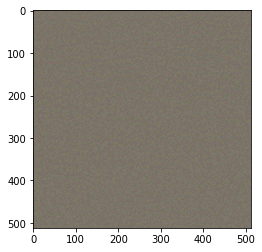

In [27]:
outputs = train_step([])
print("total loss : {}".format(outputs[0]))
print("content loss : {}".format(outputs[1]))
print("style loss : {}".format(outputs[2]))
print("tv loss : {}".format(outputs[3]))
img = outputs[4]
print(img.shape)
plt.imshow(deprocess_image(img))

In [29]:
for i in range(100):
    outputs = train_step([])
    if i%10 == 0:
        print("{}  :  {}".format(i,outputs[0]))

0  :  1732951932928.0
10  :  798644961280.0
20  :  451220668416.0
30  :  314292895744.0
40  :  222423220224.0


KeyboardInterrupt: 

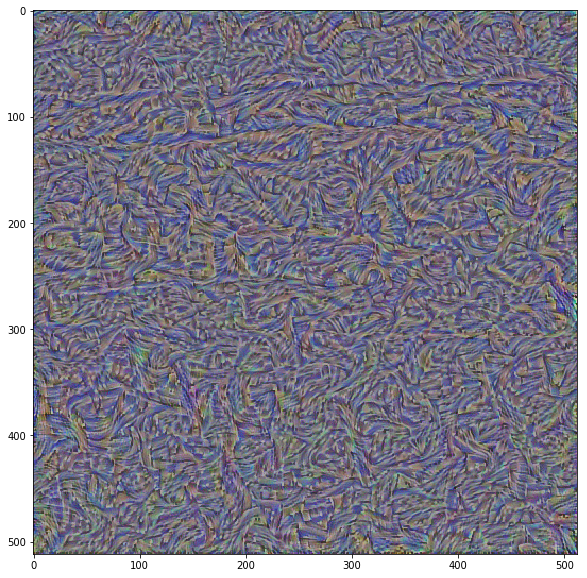

In [30]:
stylized_img = K.get_value(stylized_img_tensor)
stylized_img = deprocess_image(stylized_img)

plt.figure(figsize=(10,10))
plt.imshow(stylized_img)

## Color constraint : post - processing  

In [31]:
import cv2

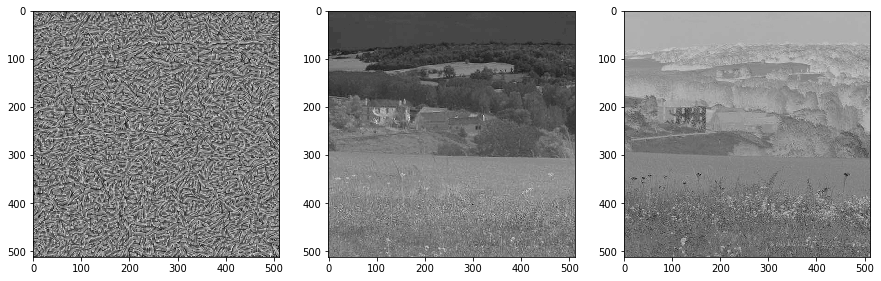

In [32]:
# from : https://github.com/cysmith/neural-style-tf/blob/master/neural_style.py
# YUV 
cvt_type = cv2.COLOR_RGB2YUV
inv_cvt_type = cv2.COLOR_YUV2RGB


content_cvt = cv2.cvtColor(content_img_raw, cvt_type)
stylized_cvt = cv2.cvtColor(stylized_img, cvt_type)

c1, _, _ = cv2.split(stylized_cvt)
_, c2, c3 = cv2.split(content_cvt)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(c1, 'gray')
plt.subplot(132)
plt.imshow(c2, 'gray')
plt.subplot(133)
plt.imshow(c3, 'gray')

merged = cv2.merge((c1, c2, c3))
stylized_img_color = cv2.cvtColor(merged, inv_cvt_type)

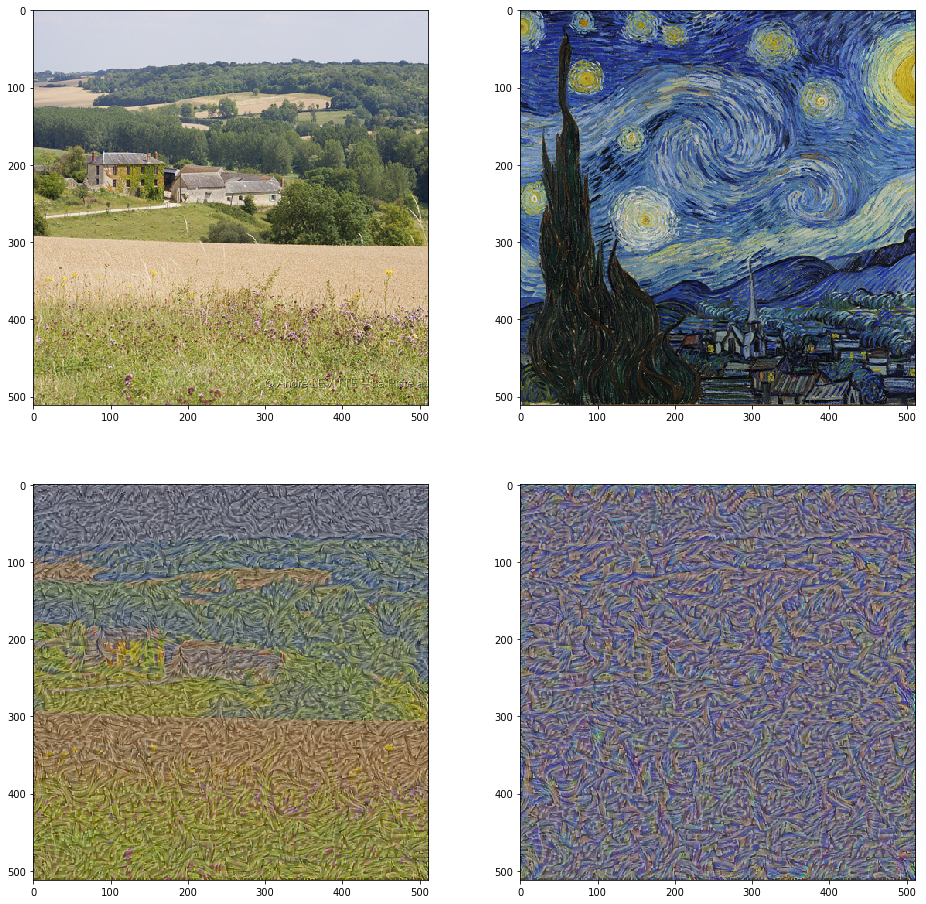

In [33]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(content_img_raw)
plt.subplot(222)
plt.imshow(style_img_raw)
plt.subplot(223)
plt.imshow(stylized_img_color)
plt.subplot(224)
plt.imshow(stylized_img)